In [13]:
# 1) Setup & safety switch (seeds, imports, dataset root)
import os, glob, collections, itertools, json
import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# --- config ---
SEED = 42
RUN_FINAL_TEST = False   # flip to True ONLY when tuning is finished

# seeds / determinism
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED); tf.random.set_seed(SEED)

# data
CLASSES   = ["paper","rock","scissors"]
DATA_ROOT = "data/raw"           # 'paper/rock/scissors' are directly inside here
IMG_SIZE  = (150, 150)

/Users/skmazhit/Desktop/rps-cnn/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [14]:
# 2) Quick EDA (count images per class)

def index_images(root):
    X, y = [], []
    for ci, cname in enumerate(CLASSES):
        for ext in ("*.png","*.jpg","*.jpeg"):
            for fp in glob.glob(os.path.join(root, "**", cname, ext), recursive=True):
                X.append(fp); y.append(ci)
    return np.array(X), np.array(y)

X, y = index_images(DATA_ROOT)
print("Found", len(X), "images")
from collections import Counter
cnt = Counter(y)
for ci, cname in enumerate(CLASSES):
    print(f"{cname}: {cnt[ci]}")
pd.DataFrame({"path": X, "label": y}).head()


Found 2188 images
paper: 712
rock: 726
scissors: 750


,path,label
0,data/raw/paper/W79peyAyfQqNP1vF.png,0
1,data/raw/paper/7ZGsbIMypDIEZxR0.png,0
2,data/raw/paper/DsaaqkHZUN3pmcwH.png,0
3,data/raw/paper/P1STllnKDD05zo29.png,0
4,data/raw/paper/RlpqfQnTgM6AxUNs.png,0


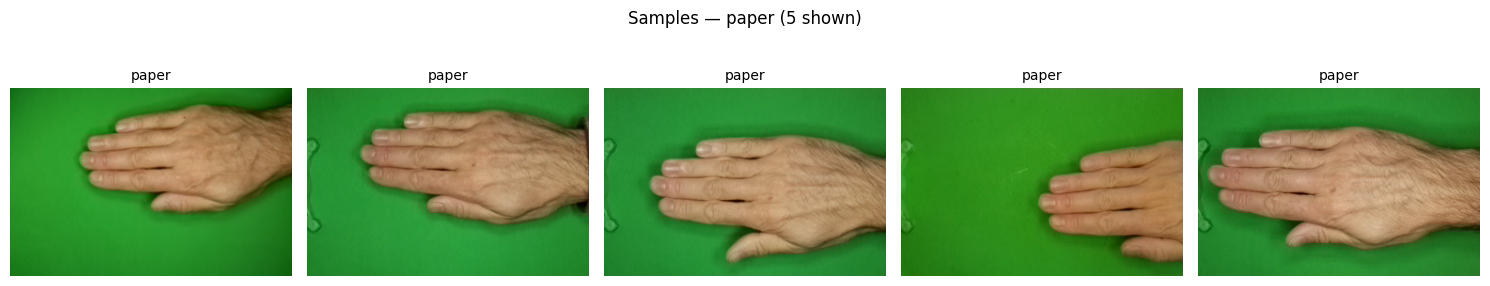

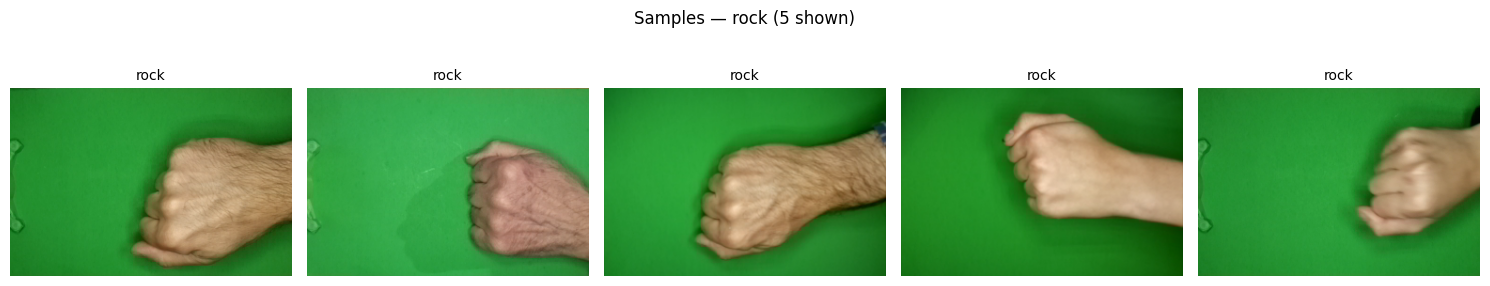

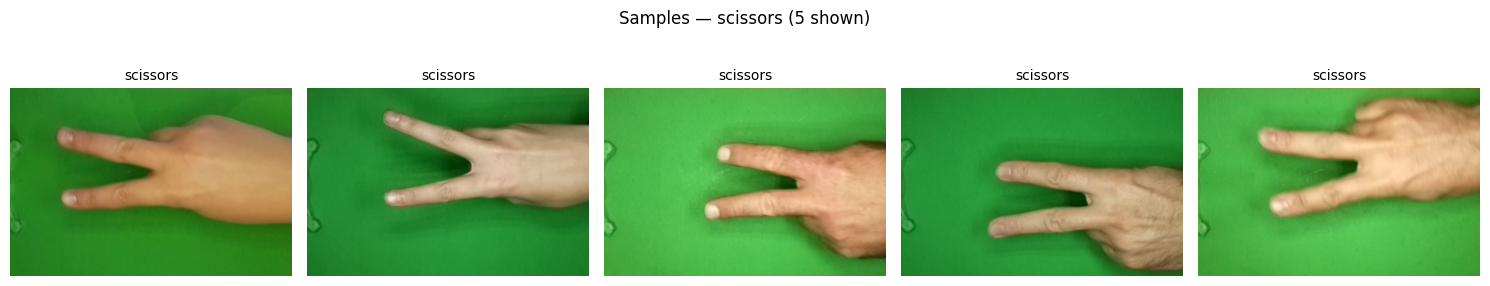

In [15]:
# Visual sanity-check: sample images per class (from DATA_ROOT)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def _find_images_for_class(root, class_name):
    exts = ("*.jpg","*.jpeg","*.png")
    files = []
    for ext in exts:
        files += glob.glob(os.path.join(root, "**", class_name, ext), recursive=True)
    return files

def show_samples(class_name, n=5, shuffle=True):
    files = _find_images_for_class(DATA_ROOT, class_name)
    if not files:
        print(f"No images found for class '{class_name}' under {DATA_ROOT}")
        return
    k = min(n, len(files))
    if shuffle:
        rng = np.random.default_rng(SEED)
        files = rng.choice(files, size=k, replace=False)
    else:
        files = files[:k]

    plt.figure(figsize=(3*k, 3))
    for i, img_path in enumerate(files, 1):
        img = mpimg.imread(img_path)
        plt.subplot(1, k, i)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(img_path)), fontsize=10)
        plt.axis("off")
    plt.suptitle(f"Samples — {class_name} ({k} shown)", y=1.02)
    plt.tight_layout()
    plt.show()

for cls in CLASSES:
    show_samples(cls, n=5)


In [16]:
# 3) Fixed stratified train/val/test splits (saved to disk)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.15, stratify=y, random_state=SEED)
X_tr, X_va, y_tr, y_va = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=SEED)

os.makedirs("splits", exist_ok=True)
def save_list(arr, path):
    with open(path, "w") as f:
        for a in arr: f.write(a + "\n")

save_list(X_tr, "splits/train.txt")
save_list(X_va, "splits/val.txt")
save_list(X_te, "splits/test.txt")

print("Saved splits to splits/train.txt, splits/val.txt, splits/test.txt")


Saved splits to splits/train.txt, splits/val.txt, splits/test.txt


In [17]:
# 4) tf.data pipeline (resize+normalize; augmentation train-only)

def load_split(txt):
    with open(txt) as f:
        X=[ln.strip() for ln in f if ln.strip()]
    y=[]
    for fp in X:
        fp_norm = fp.replace("/", os.sep); lab=None
        for i,c in enumerate(CLASSES):
            if os.sep + c + os.sep in fp_norm: lab=i; break
        if lab is None: raise ValueError(f"Cannot infer class for {fp}")
        y.append(lab)
    return np.array(X), np.array(y)

def make_ds(filepaths, labels, img_size=IMG_SIZE, batch=32, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    def _load(fp, y):
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img, y
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle: ds = ds.shuffle(2048, seed=SEED, reshuffle_each_iteration=True)
    if augment:
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch).cache().prefetch(tf.data.AUTOTUNE)


In [18]:
# 5) Three CNN architectures (Tiny, Base, Deep)

def TinyCNN(input_shape=(150,150,3), n_classes=3, dr=0.3):
    i = tf.keras.Input(input_shape)
    x = tf.keras.layers.Conv2D(32,3,padding="same")(i); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dr)(x)
    o = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(i, o, name="TinyCNN")

def BaseCNN(input_shape=(150,150,3), n_classes=3, dr1=0.4, dr2=0.5):
    i = tf.keras.Input(input_shape); x = i
    for f in [32,64,128]:
        x = tf.keras.layers.Conv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Conv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dr1)(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(dr2)(x)
    o = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(i, o, name="BaseCNN")

def DeepCNN(input_shape=(150,150,3), n_classes=3, dr=0.5):
    i = tf.keras.Input(input_shape); x = i
    for f in [32,64,128,256]:
        x = tf.keras.layers.SeparableConv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.SeparableConv2D(f,3,padding="same")(x); x = tf.keras.layers.BatchNormalization()(x); x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dr)(x)
    o = tf.keras.layers.Dense(n_classes, activation="softmax")(x)
    return tf.keras.Model(i, o, name="DeepCNN")



In [19]:
# 6) Train Tiny/Base/Deep; compare on validation

def compile_model(m, lr=1e-3):
    m.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
    return m

Xtr, ytr = load_split("splits/train.txt")
Xva, yva = load_split("splits/val.txt")
train_ds = make_ds(Xtr, ytr, batch=32, shuffle=True, augment=True)
val_ds   = make_ds(Xva, yva, batch=32)

models = [TinyCNN(), BaseCNN(), DeepCNN()]
histories = {}
for m in models:
    m = compile_model(m, lr=1e-3)
    h = m.fit(
        train_ds, validation_data=val_ds, epochs=40, verbose=1,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)
        ]
    )
    histories[m.name] = h.history

print("Trained:", list(histories.keys()))



2025-10-19 18:42:08.362615: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-10-19 18:42:08.362654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-10-19 18:42:08.362663: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-10-19 18:42:08.362694: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-19 18:42:08.362712: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/40


2025-10-19 18:42:09.299732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.4618 - loss: 1.0744 - val_accuracy: 0.3306 - val_loss: 1.0958 - learning_rate: 0.0010
Epoch 2/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5814 - loss: 0.9023 - val_accuracy: 0.3306 - val_loss: 1.1101 - learning_rate: 0.0010
Epoch 3/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.6003 - loss: 0.8414 - val_accuracy: 0.3306 - val_loss: 1.1190 - learning_rate: 0.0010
Epoch 4/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6573 - loss: 0.7860 - val_accuracy: 0.3871 - val_loss: 1.1296 - learning_rate: 0.0010
Epoch 5/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7201 - loss: 0.7021 - val_accuracy: 0.4704 - val_loss: 1.2034 - learning_rate: 5.0000e-04
Epoch 6/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - accuracy: 0.7180 - loss: 0.6870 - val_accuracy: 0.4086 - val_loss: 1.3035 - learning_rate: 5.0000e-04
Epoch 7/40
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.7519 - loss: 0.6702 - val_accur

In [20]:
# 7) Grid search with 3-fold CV on TRAIN ONLY 
grid = {"lr":[1e-2, 1e-3, 3e-4], "dr1":[0.3, 0.4, 0.5], "batch":[32, 64]}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

results=[]
for lr, dr1, batch in itertools.product(grid["lr"], grid["dr1"], grid["batch"]):
    fold_scores=[]
    for tr_idx, va_idx in skf.split(Xtr, ytr):
        ds_tr = make_ds(Xtr[tr_idx], ytr[tr_idx], batch=batch, shuffle=True, augment=True)
        ds_va = make_ds(Xtr[va_idx], ytr[va_idx], batch=batch)
        m = BaseCNN(dr1=dr1, dr2=0.5)
        m.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        m.fit(ds_tr, validation_data=ds_va, epochs=30, verbose=0,
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)])

        # macro-F1 on the fold's val set
        y_true, y_pred = [], []
        for xb, yb in ds_va:
            pr = m.predict(xb, verbose=0).argmax(-1)
            y_pred.extend(pr.tolist()); y_true.extend(yb.numpy().tolist())
        fold_scores.append(f1_score(y_true, y_pred, average="macro"))
    results.append({"lr":lr,"dr1":dr1,"batch":batch,"mean_macro_f1": float(np.mean(fold_scores))})

results = sorted(results, key=lambda d: d["mean_macro_f1"], reverse=True)
print(json.dumps(results[:5], indent=2))
best = results[0]
best


2025-10-19 18:49:44.643558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-19 18:56:25.300839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-19 19:00:09.773249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-19 19:01:48.375678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-19 19:02:53.095363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-19 19:04:38.070271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-10-19 19:07:36.484800: W tensorflow/core/framework/local_rendezvous.cc:404] L

In [ ]:
# 8) Retrain best on TRAIN+VAL; evaluate ONCE on TEST (accuracy/precision/recall/F1 + CM)

# Train on TRAIN+VAL
X_all = np.concatenate([Xtr, Xva]); y_all = np.concatenate([ytr, yva])
ds_all = make_ds(X_all, y_all, batch=best['batch'], shuffle=True, augment=True)

final = BaseCNN(dr1=best['dr1'], dr2=0.5)
final.compile(optimizer=tf.keras.optimizers.Adam(best['lr']),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final.fit(ds_all, epochs=50, verbose=1,
          callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
                     tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)])

if not RUN_FINAL_TEST:
    print("Skipping FINAL TEST to avoid leakage. Set RUN_FINAL_TEST=True when ready.")
else:
    Xte, yte = load_split("splits/test.txt")         # first & only time we touch test
    ds_te = make_ds(Xte, yte, batch=best['batch'])

    y_true, y_pred = [], []
    for xb, yb in ds_te:
        pr = final.predict(xb, verbose=0).argmax(-1)
        y_pred.extend(pr.tolist()); y_true.extend(yb.numpy().tolist())

    print(classification_report(y_true, y_pred, target_names=CLASSES, digits=4))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

    # (optional) list a few mistakes
    wrong = [(i,t,p) for i,(t,p) in enumerate(zip(y_true,y_pred)) if t!=p]
    print("Misclassified:", len(wrong))
    for i,(idx,t,p) in enumerate(wrong[:10]):
        print(f"{i}: true={CLASSES[t]} pred={CLASSES[p]}")


NameError: name 'np' is not defined

In [ ]:
# 9) Save confusion-matrix plot for the report (optional)

if RUN_FINAL_TEST:
    import matplotlib.pyplot as plt
    from sklearn.metrics import ConfusionMatrixDisplay
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
    import os; os.makedirs("reports", exist_ok=True)
    _, ax = plt.subplots()
    disp.plot(ax=ax, values_format='d', colorbar=False)
    plt.title('Test Confusion Matrix')
    plt.savefig("reports/test_confusion_matrix.png", dpi=150, bbox_inches='tight')
    print("Saved to reports/test_confusion_matrix.png")
